In [2]:
%pylab inline
import json 
import os
import re
import boto3
import uuid
import base64
import sagemaker as sm
import subprocess
from glob import glob
from tqdm import tqdm
from PIL import Image
from tracking_funcs import *
import datetime
import numpy as np
from scipy.spatial import distance
from matplotlib import patches
from sagemaker.predictor import RealTimePredictor
from sagemaker.predictor import numpy_deserializer, npy_serializer

# realPredictor = RealTimePredictor(endpointName, serializer= npy_serializer, deserializer= numpy_deserializer)

sagemaker_cl = boto3.client('sagemaker')
sagemaker_rt = boto3.client('runtime.sagemaker')
bucket = 'privisaa-bucket-virginia'
s3 = boto3.client('s3')

WORKTEAM_ARN = 'arn:aws:sagemaker:us-east-1:209419068016:workteam/private-crowd/ijp-private-workteam'


Populating the interactive namespace from numpy and matplotlib


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [83]:
#!aws s3 cp --recursive s3://privisaa-bucket-virginia/nfl-data/game_clips/ /home/ec2-user/SageMaker/game_clips
!aws s3 cp --recursive s3://privisaa-bucket-virginia/nfl-data/live_video/ /home/ec2-user/SageMaker/game_clips

download: s3://privisaa-bucket-virginia/nfl-data/live_video/2020-07-17-21:04:23.025826/split_frames_00002.jpg to ../../game_clips/2020-07-17-21:04:23.025826/split_frames_00002.jpg
download: s3://privisaa-bucket-virginia/nfl-data/live_video/2020-07-17-21:04:23.025826/split_frames_00006.jpg to ../../game_clips/2020-07-17-21:04:23.025826/split_frames_00006.jpg
download: s3://privisaa-bucket-virginia/nfl-data/live_video/2020-07-17-21:04:23.025826/split_frames_00004.jpg to ../../game_clips/2020-07-17-21:04:23.025826/split_frames_00004.jpg
download: s3://privisaa-bucket-virginia/nfl-data/live_video/2020-07-17-21:04:23.025826/split_frames_00003.jpg to ../../game_clips/2020-07-17-21:04:23.025826/split_frames_00003.jpg
download: s3://privisaa-bucket-virginia/nfl-data/live_video/2020-07-17-21:04:23.025826/split_frames_00007.jpg to ../../game_clips/2020-07-17-21:04:23.025826/split_frames_00007.jpg
download: s3://privisaa-bucket-virginia/nfl-data/live_video/2020-07-17-21:04:23.025826/split_frames_

In [3]:
# create label categories 

output = subprocess.check_output(['aws', 's3', 'ls', f's3://{bucket}/nfl-data/football_label_categories.json']).decode('utf-8').replace('\n','')

if output.split(' ')[-1]=='football_label_categories.json':
    labelcats = {
        "document-version": "2020-03-01",
        "auditLabelAttributeName": "Person",
        "categoryGlobalAttributes": [
            {
                "name": "applyToAllCategory",
                "description": "global attribute that applies to all label categories",
                "type": "string",
                "enum": [
                    "foo",
                ]
            }
        ],
        "labels": [
            {
                "label": "Helmet",
                "attributes": [
                    {
                        "name": "color",
                        "type": "string",
                        "enum": [
                            "Red",
                            "Blue",
                            "Silver"
                        ]
                    }
                ]
            }
        ],
        "instructions": {
            "shortInstruction": "Draw boxes around all ducks in the pictures",
            "fullInstruction": "Some useful instruction"
        }
    }

    filename = '/home/ec2-user/SageMaker/game_clips/football_label_categories.json'
    with open(filename,'w') as f:
        json.dump(labelcats,f)

    s3.upload_file(Filename=filename, Bucket=bucket, Key='nfl-data/football_label_categories.json')

LABEL_CATEGORIES_S3_URI = f's3://{bucket}/nfl-data/football_label_categories.json'

In [28]:
# subprocess.run(['aws', 's3', 'cp', f's3://{bucket}/nfl-data/game_clips/','game_clips'])

CompletedProcess(args=['aws', 's3', 'cp', 's3://privisaa-bucket-virginia/nfl-data/game_clips/', 'game_clips'], returncode=0)

In [4]:
# get our target MP4 files, 
vids = glob('/home/ec2-user/SageMaker/game_clips/2020*') 
vids.sort()
vids

# we assume we have folders with the same name as the mp4 file in the same root folder
vid_dict = {}
for vid in vids:
    files = glob(f"{vid}/*jpg")
    files.sort()
    files = files[:1000]
    fileset = []
    for fil in files:
        fileset.append('/'.join(fil.split('/')[4:]))
    vid_dict[vid] = fileset

In [5]:
# generate sequences 
all_vids = {}
for vid in vid_dict:
    frames = []
    for i,v in enumerate(vid_dict[vid]):
        frame =         {
          "frame-no": i+1,
          "frame": f"{v.split('/')[-1]}",
          "unix-timestamp": 1589350528
        }
        frames.append(frame)
    all_vids[vid] = {
      "version": "2020-07-01",
      "seq-no": 1,
      "prefix": f"s3://{bucket}/nfl-data/live_video/{v.split('/')[1]}/",
      "number-of-frames": len(vid_dict[vid]),
      "frames": frames
    }

In [6]:
# save sequences
for vid in all_vids:
    with open(f"/home/ec2-user/SageMaker/nfl-data/gt_jobs/{vid.split('/')[-1]}_seq.json", 'w') as f:
        json.dump(all_vids[vid],f)

In [7]:
#%%timeit
endpoint_name = 'd2-endpoint-Thu-Jul-16-15-24-57-2020'

imgs = {}
preds = {}
for vid in tqdm(vid_dict):
    preds[vid] = []
    imgs[vid] = []
    for file in vid_dict[vid]:
        img = Image.open(f'/home/ec2-user/SageMaker/{file}')
        img = np.array(img, dtype=np.uint8) # np.uint8

        response = sagemaker_rt.invoke_endpoint(EndpointName=endpoint_name,
                                               ContentType='application/x-npy', # application/x-npy
                                               Body=npy_serializer(img)) # json.dumps(payload) # img.tobytes()
        response = eval(response['Body'].read().decode('utf-8'))
        preds[vid].append(response)
        imgs[vid].append(img)
        

100%|██████████| 1/1 [00:34<00:00, 34.61s/it]


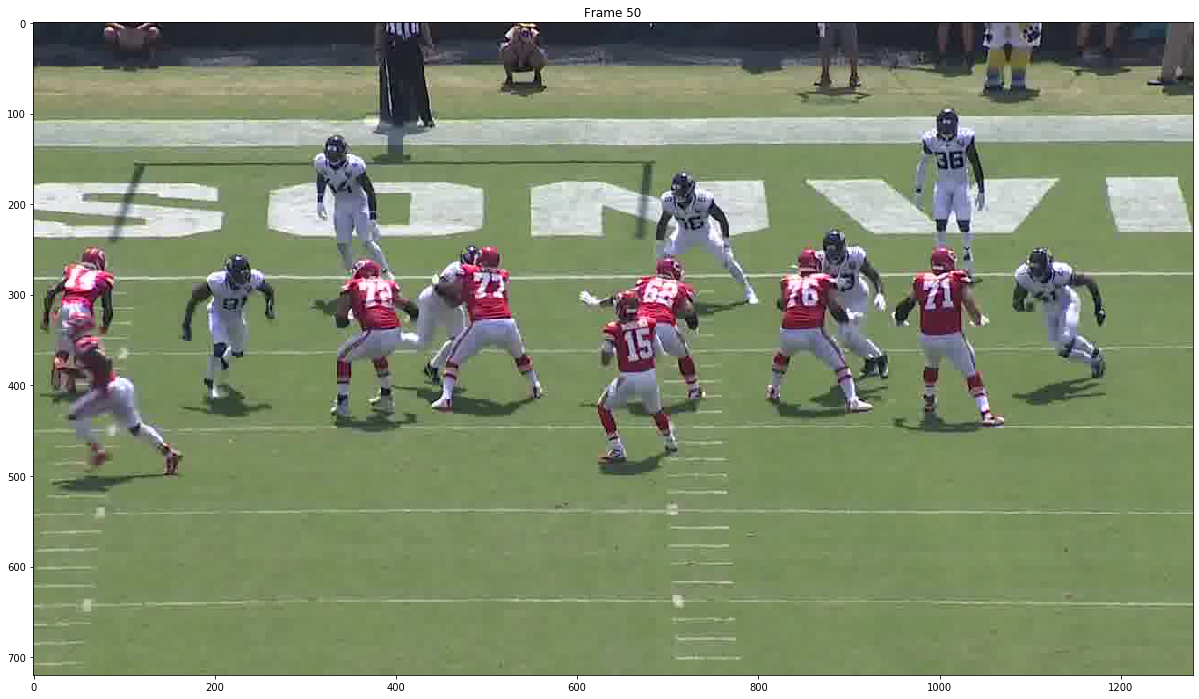

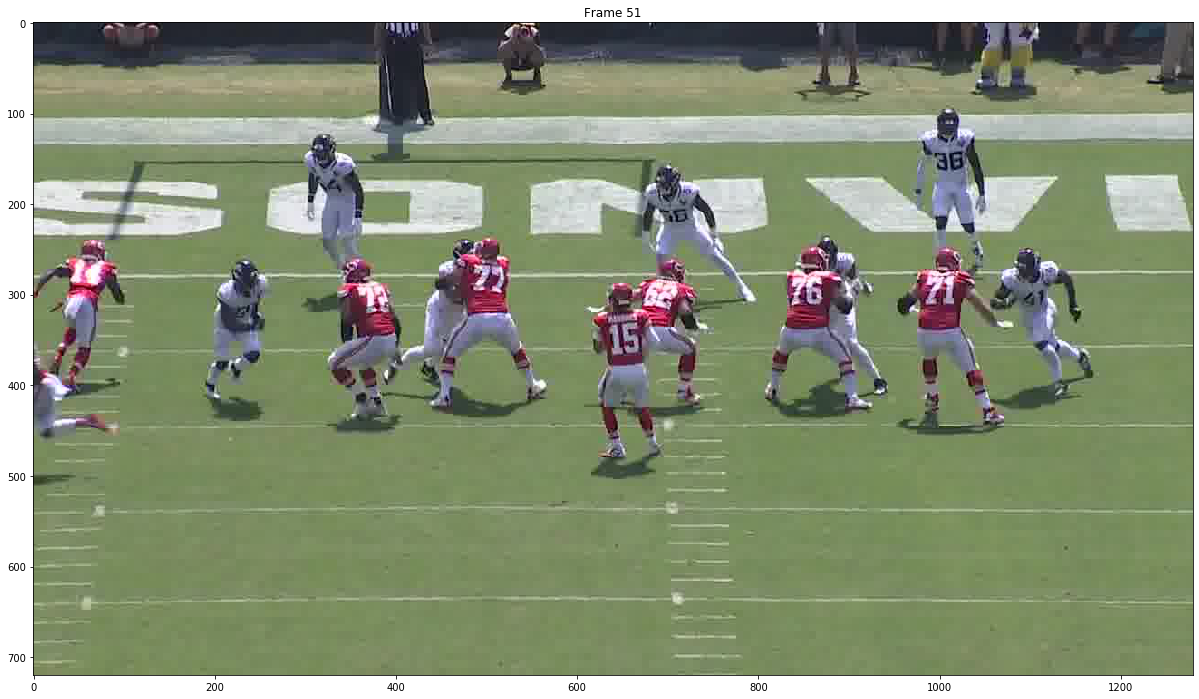

In [9]:
start_ind = 50
#[5,100,200,300,400]
for j in range(start_ind,start_ind+2): #,300,400,500

    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(24,12))
    ax.set_title(f'Frame {j}')

    # Display the image
    ax.imshow(imgs[vid][j])

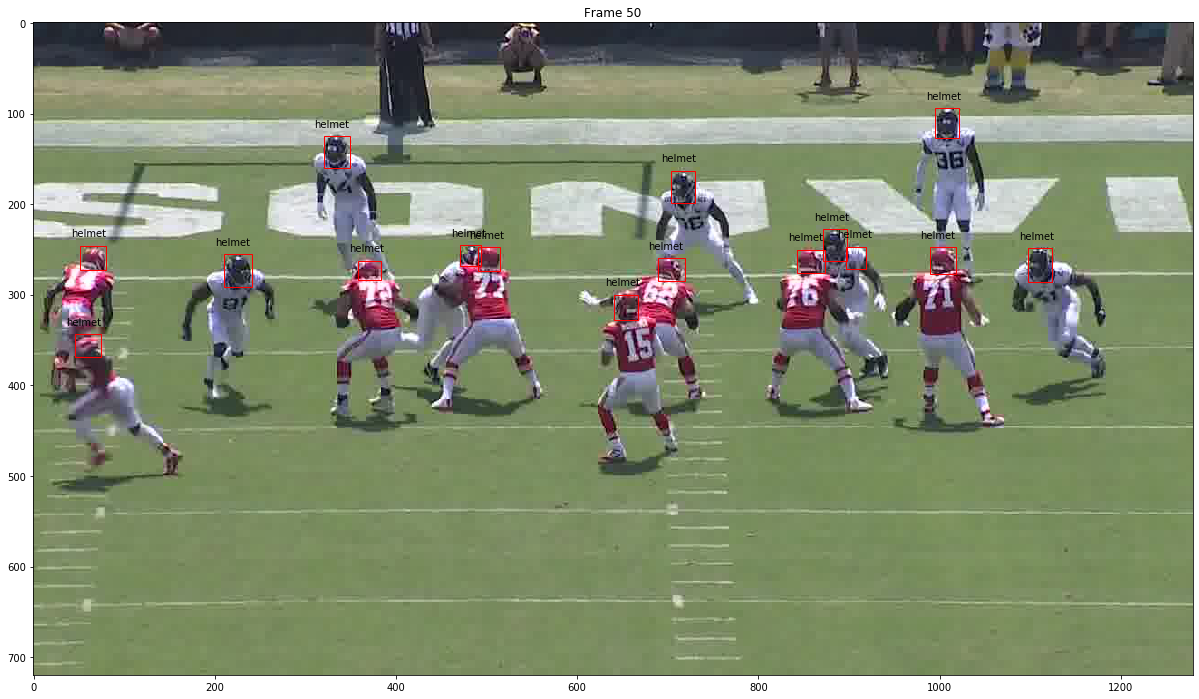

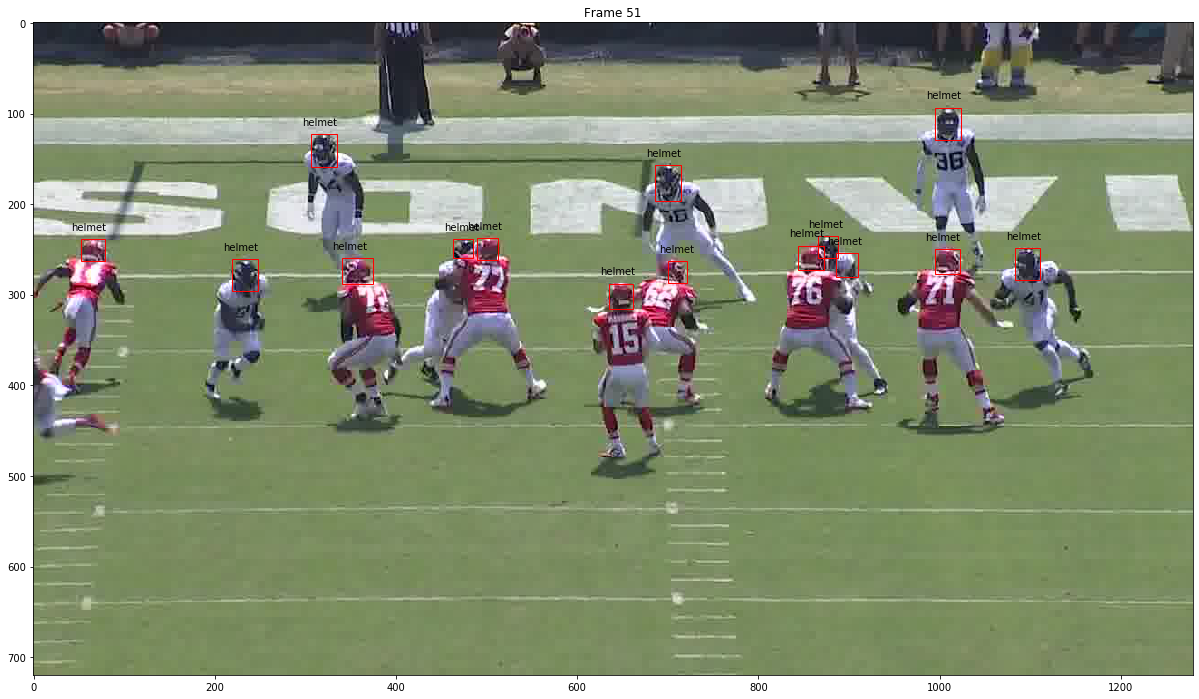

In [8]:
start_ind = 50
#[5,100,200,300,400]
for j in range(start_ind,start_ind+2): #,300,400,500

    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(24,12))
    ax.set_title(f'Frame {j}')

    # Display the image
    ax.imshow(imgs[vid][j])

    for i,annot in enumerate(preds[vid][j]['pred_boxes']): # ['tracking-annotations'][0]
        #print(annot['height']*annot['width'])
        #if(annot['height']*annot['width'])
        rect = patches.Rectangle((annot[0], annot[1]), annot[2]-annot[0], annot[3]-annot[1] ,linewidth=1,edgecolor='r',facecolor='none') # 50,100),40,30
        ax.add_patch(rect)
#         try:
        plt.text(annot[0]-10, annot[1]-10, f"helmet", fontdict=None) # 

In [12]:
# get distances 
helmet_id_dict = {}

for vid in preds:
    helmet_dist = get_object_distances(preds[vid])

    helmet_ids = {}
    helmet_id = []
    for i in helmet_dist:
        helmet_id = []
        for h in helmet_dist[i]:
            helmet_id.append(np.argmin(helmet_dist[i][h]))
        helmet_ids[i] = helmet_id

    print(f'there are {len(find_dups(helmet_ids))} duplicates')   

    for i in range(7):
        verbose=True
        dups = find_dups(helmet_ids)
        if verbose:
            print(f'dups before {dups}')
        helmet_ids = dedupe_helmets(dups, helmet_ids, helmet_dist, verbose=False)
        dups = find_dups(helmet_ids)
        if verbose:
            print(f'dups after {dups}')
    helmet_id_dict[vid] = helmet_ids

there are 131 duplicates
dups before [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135]
dups after [4, 22, 23, 29, 31, 32, 36, 37, 42, 43, 44, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135]
dups b

In [28]:
helmet_ids

{1: [2, 0, 3, 1, 5, 4, 6, 8, 7, 9, 11, 10, 12],
 2: [2, 1, 6, 3, 4, 0, 5, 7, 9, 8, 10, 11, 12],
 3: [2, 3, 4, 6, 5, 1, 0, 8, 7, 11, 9, 10, 12],
 4: [4, 2, 0, 1, 7, 3, 5, 6, 8, 10, 9, 11, 12, 13, 14, 15],
 5: [1, 7, 5, 3, 0, 2, 6, 8, 9, 4, 11, 10, 12, 13],
 6: [5, 7, 0, 1, 3, 4, 2, 6, 9, 10, 11, 8, 12, 13],
 7: [1, 7, 0, 3, 2, 5, 6, 4, 9, 11, 10, 8, 12, 13, 14],
 8: [7, 4, 5, 0, 2, 3, 1, 6, 9, 10, 11, 13, 8, 12, 14],
 9: [0, 7, 1, 5, 4, 10, 3, 2, 6, 9, 8, 12, 11, 13],
 10: [7, 4, 1, 5, 0, 2, 3, 6, 9, 10, 8, 13, 12, 11],
 11: [3, 7, 1, 0, 4, 5, 13, 2, 10, 6, 12, 9, 8, 11, 14],
 12: [7, 5, 3, 2, 0, 10, 4, 9, 1, 12, 6, 13, 11, 8, 14, 15],
 13: [3, 7, 4, 0, 2, 5, 1, 10, 6, 12, 8, 11, 9, 13, 14],
 14: [3, 5, 0, 4, 7, 12, 6, 2, 10, 8, 9, 13, 11, 1],
 15: [3, 5, 7, 4, 0, 6, 12, 10, 9, 1, 2, 11, 8],
 16: [3, 0, 5, 10, 7, 4, 9, 1, 2, 12, 13, 6, 11, 14, 8],
 17: [5, 3, 0, 1, 7, 2, 4, 9, 12, 10, 11, 8, 6, 13],
 18: [7, 3, 5, 2, 4, 1, 9, 10, 0, 12, 8, 13, 6, 14],
 19: [3, 7, 5, 1, 9, 10, 13, 2, 0, 

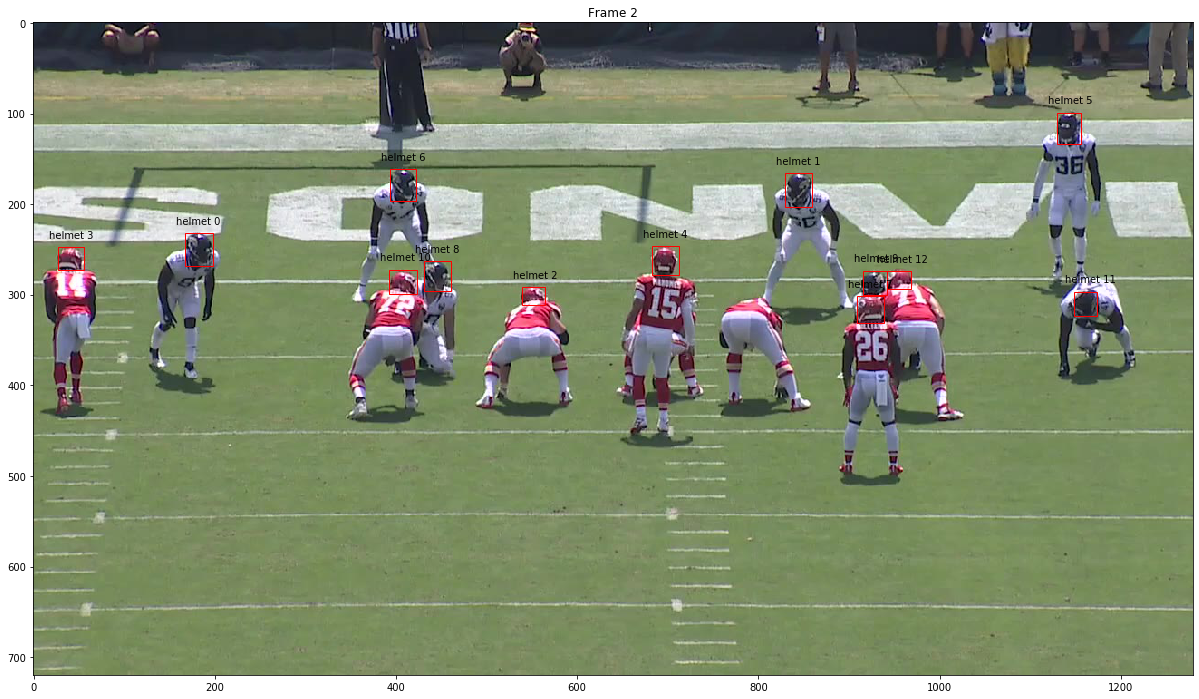

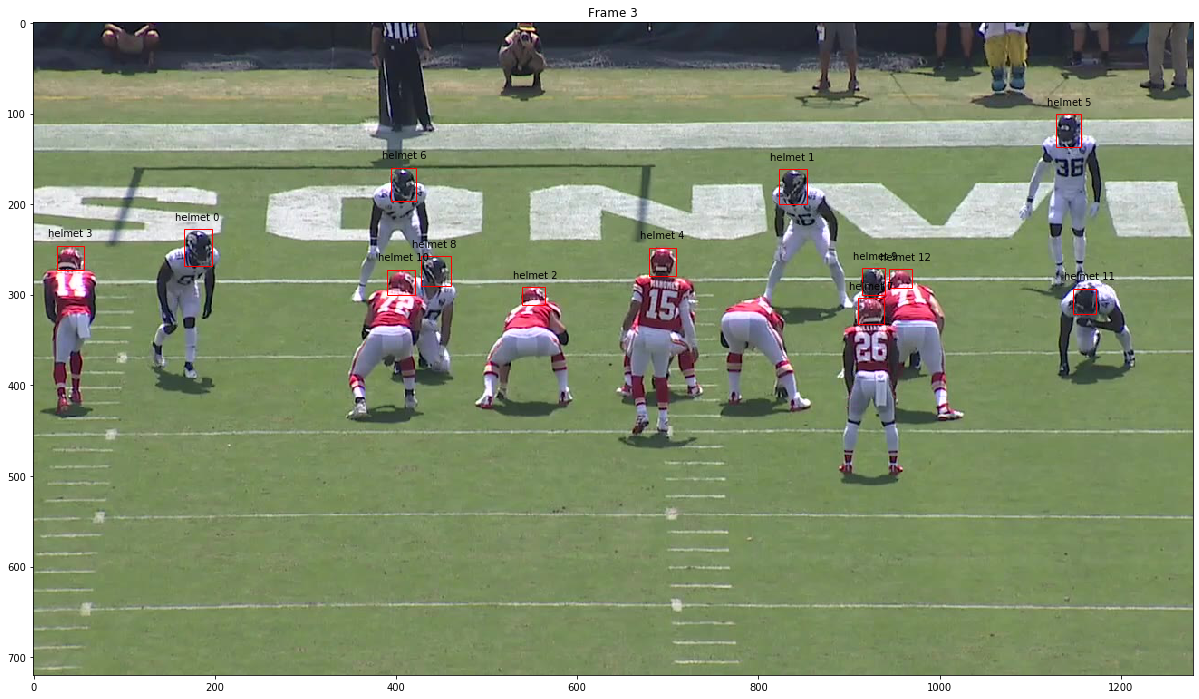

In [13]:
start_ind = 2
#[5,100,200,300,400]
for j in range(start_ind,start_ind+2): #,300,400,500

    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(24,12))
    ax.set_title(f'Frame {j}')

    # Display the image
    ax.imshow(imgs[vid][j])

    for i,annot in enumerate(preds[vid][j]['pred_boxes']): # ['tracking-annotations'][0]
        #print(annot['height']*annot['width'])
        #if(annot['height']*annot['width'])
        rect = patches.Rectangle((annot[0], annot[1]), annot[2]-annot[0], annot[3]-annot[1] ,linewidth=1,edgecolor='r',facecolor='none') # 50,100),40,30
        ax.add_patch(rect)
#         try:
        plt.text(annot[0]-10, annot[1]-10, f"helmet {helmet_ids[j][i]}", fontdict=None) # 

In [16]:
annot_dict = {}
for vid in preds:
    annot_list = []
    for i,pred in enumerate(preds[vid]):
        annl = []
        for j,p in enumerate(preds[vid][i]['pred_boxes']):
            try:
                idx = helmet_ids[i+1][j]
            except:
                try:
                    idx = max(helmet_ids[i+1])+1
                except:
                    pass
            ann = {
                'class-id':'0',
#                 'label':'Helmet',
                'object-id':f'Helmet:{idx}',
                'object-name':f'H{idx}', # str(uuid.uuid1())
                'width':int(p[2]-p[0]),
                'top':int(p[1]),
                'height':int(p[3]-p[1]),
                'left':int(p[0]),
                'label-category-attributes':{}
            }
            annl.append(ann)
        annot = {
            'frame-no':i+1,
            'frame':all_vids[vid]['frames'][i]['frame'],
            'annotations':annl
        }
        annot_list.append(annot)

    annot_labels = {}
    annot_labels['tracking-annotations'] = annot_list
    annot_dict[vid] = annot_labels
    

In [25]:
annot_dict[vid]['tracking-annotations']

[{'frame-no': 1,
  'frame': 'split_frames_00001.jpg',
  'annotations': [{'class-id': '0',
    'object-id': 'Helmet:2',
    'object-name': 'H2',
    'width': 31,
    'top': 233,
    'height': 38,
    'left': 167,
    'label-category-attributes': {}},
   {'class-id': '0',
    'object-id': 'Helmet:0',
    'object-name': 'H0',
    'width': 28,
    'top': 167,
    'height': 35,
    'left': 831,
    'label-category-attributes': {}},
   {'class-id': '0',
    'object-id': 'Helmet:3',
    'object-name': 'H3',
    'width': 25,
    'top': 291,
    'height': 19,
    'left': 538,
    'label-category-attributes': {}},
   {'class-id': '0',
    'object-id': 'Helmet:1',
    'object-name': 'H1',
    'width': 29,
    'top': 246,
    'height': 25,
    'left': 26,
    'label-category-attributes': {}},
   {'class-id': '0',
    'object-id': 'Helmet:5',
    'object-name': 'H5',
    'width': 30,
    'top': 246,
    'height': 32,
    'left': 682,
    'label-category-attributes': {}},
   {'class-id': '0',
    'o

In [18]:
# save labels
for vid in all_vids:
    with open(f"/home/ec2-user/SageMaker/nfl-data/gt_jobs/{vid.split('/')[-1]}-labels.json", 'w') as f:
        json.dump(annot_dict[vid],f)

In [19]:
# create manifest 
man_dict = {}
for vid in all_vids:
    source_ref = f"s3://{bucket}/nfl-data/gt_jobs/{vid.split('/')[-1]}_seq.json"
    print(source_ref)
    annot_labels = f"s3://{bucket}/nfl-data/gt_jobs/{vid.split('/')[-1]}-labels.json"

    manifest = {
        "source-ref": source_ref, 
     #describe_job['LabelAttributeName']: annot_labels, 
        'Person':annot_labels,
     #f"{describe_job['LabelAttributeName']}-metadata": 
        "Person-metadata":{"class-map": {"0": "Helmet"}, 
                         "human-annotated": "yes", 
                         "creation-date": "2020-05-25T12:53:54+0000", 
                         "type": "groundtruth/video-object-tracking"}}
    man_dict[vid] = manifest

s3://privisaa-bucket-virginia/nfl-data/gt_jobs/2020-07-17-21:04:23.025826_seq.json


In [20]:
# save labels
for vid in all_vids:
    with open(f"/home/ec2-user/SageMaker/nfl-data/gt_jobs/{vid.split('/')[-1]}.manifest", 'w') as f:
        json.dump(man_dict[vid],f)

In [21]:
# send files to s3

for file in glob(f"/home/ec2-user/SageMaker/nfl-data/gt_jobs/{vid.split('/')[-1]}*"):
    key = f"nfl-data/gt_jobs/{file.split('/')[-1]}"
    s3.upload_file(Filename=file,Bucket=bucket,Key=key)

In [22]:
# generate jobs 

job_names = []
outputs = []

for vid in all_vids:
    task = 'AdjustmentVideoObjectTracking'
    LABELING_JOB_NAME = f"nfl-example-job-tst11-noref-{vid.split('/')[-1].replace(':','-').split('.')[0]}"
    job_names.append(LABELING_JOB_NAME)
    INPUT_MANIFEST_S3_URI = f"s3://{bucket}/nfl-data/gt_jobs/{vid.split('/')[-1]}.manifest"

    createLabelingJob_request = {
      "LabelingJobName": LABELING_JOB_NAME,
      "HumanTaskConfig": {
        "AnnotationConsolidationConfig": {
          "AnnotationConsolidationLambdaArn": f"arn:aws:lambda:us-east-1:432418664414:function:ACS-{task}"
        }, # changed us-west-2 to us-east-1
        "MaxConcurrentTaskCount": 200,
        "NumberOfHumanWorkersPerDataObject": 1,
        "PreHumanTaskLambdaArn": f"arn:aws:lambda:us-east-1:432418664414:function:PRE-{task}",
        "TaskAvailabilityLifetimeInSeconds": 864000,
        "TaskDescription": "Draw boxes around ducks!",
        "TaskKeywords": [
          "Image Classification",
          "Labeling"
        ],
        "TaskTimeLimitInSeconds": 28800,
        "TaskTitle": LABELING_JOB_NAME,
        "UiConfig": {
          "HumanTaskUiArn": f'arn:aws:sagemaker:us-east-1:394669845002:human-task-ui/VideoObjectTracking'
        },
        "WorkteamArn": WORKTEAM_ARN
      },
      "InputConfig": {
        "DataAttributes": {
          "ContentClassifiers": [
            "FreeOfPersonallyIdentifiableInformation",
            "FreeOfAdultContent"
          ]
        },
        "DataSource": {
          "S3DataSource": {
            "ManifestS3Uri": INPUT_MANIFEST_S3_URI
          }
        }
      },
      "LabelAttributeName": "Person-ref",
      "LabelCategoryConfigS3Uri": LABEL_CATEGORIES_S3_URI,
      "OutputConfig": {
        "S3OutputPath": f"s3://{bucket}/job_results"
      },
      "RoleArn": "arn:aws:iam::209419068016:role/service-role/AmazonSageMaker-ExecutionRole-20200212T154382",
      "StoppingConditions": {
        "MaxPercentageOfInputDatasetLabeled": 100
      }
    }
    print(createLabelingJob_request)
    out = sagemaker_cl.create_labeling_job(**createLabelingJob_request)
    outputs.append(out)
    print(out)

{'LabelingJobName': 'nfl-example-job-tst11-noref-2020-07-17-21-04-23', 'HumanTaskConfig': {'AnnotationConsolidationConfig': {'AnnotationConsolidationLambdaArn': 'arn:aws:lambda:us-east-1:432418664414:function:ACS-AdjustmentVideoObjectTracking'}, 'MaxConcurrentTaskCount': 200, 'NumberOfHumanWorkersPerDataObject': 1, 'PreHumanTaskLambdaArn': 'arn:aws:lambda:us-east-1:432418664414:function:PRE-AdjustmentVideoObjectTracking', 'TaskAvailabilityLifetimeInSeconds': 864000, 'TaskDescription': 'Draw boxes around ducks!', 'TaskKeywords': ['Image Classification', 'Labeling'], 'TaskTimeLimitInSeconds': 28800, 'TaskTitle': 'nfl-example-job-tst11-noref-2020-07-17-21-04-23', 'UiConfig': {'HumanTaskUiArn': 'arn:aws:sagemaker:us-east-1:394669845002:human-task-ui/VideoObjectTracking'}, 'WorkteamArn': 'arn:aws:sagemaker:us-east-1:209419068016:workteam/private-crowd/ijp-private-workteam'}, 'InputConfig': {'DataAttributes': {'ContentClassifiers': ['FreeOfPersonallyIdentifiableInformation', 'FreeOfAdultCont

In [24]:
sagemaker_cl.describe_labeling_job(LabelingJobName = 'nfl-example-job-tst11-noref-2020-07-17-21-04-23')

{'LabelingJobStatus': 'InProgress',
 'LabelCounters': {'TotalLabeled': 0,
  'HumanLabeled': 0,
  'MachineLabeled': 0,
  'FailedNonRetryableError': 0,
  'Unlabeled': 1},
 'CreationTime': datetime.datetime(2020, 7, 20, 22, 35, 19, 436000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2020, 7, 20, 22, 41, 7, 726000, tzinfo=tzlocal()),
 'JobReferenceCode': '209419068016hjuY2bf0GiiIo4hn',
 'LabelingJobName': 'nfl-example-job-tst11-noref-2020-07-17-21-04-23',
 'LabelingJobArn': 'arn:aws:sagemaker:us-east-1:209419068016:labeling-job/nfl-example-job-tst11-noref-2020-07-17-21-04-23',
 'LabelAttributeName': 'Person-ref',
 'InputConfig': {'DataSource': {'S3DataSource': {'ManifestS3Uri': 's3://privisaa-bucket-virginia/nfl-data/gt_jobs/2020-07-17-21:04:23.025826.manifest'}},
  'DataAttributes': {'ContentClassifiers': ['FreeOfPersonallyIdentifiableInformation',
    'FreeOfAdultContent']}},
 'OutputConfig': {'S3OutputPath': 's3://privisaa-bucket-virginia/job_results',
  'KmsKeyId': ''},
 

In [ ]:
{
    "source-ref": "s3://privisaa-bucket-virginia/nfl-data/gt_jobs/2020-07-17-21:04:23.025826_seq.json",
    "Person-ref": "s3://privisaa-bucket-virginia/job_results/nfl-example-job-2020-07-17-21-04-23/annotations/consolidated-annotation/output/0/SeqLabel.json",
    "Person-ref-metadata": {
        "class-map": {
            "0": "Helmet"
        },
        "job-name": "labeling-job/nfl-example-job-2020-07-17-21-04-23",
        "human-annotated": "yes",
        "creation-date": "2020-07-19T16:59:25.570000",
        "type": "groundtruth/video-object-tracking"
    }
}

In [116]:
!aws s3 cp s3://privisaa-bucket-virginia/job_results/nfl-example-job-2020-07-17-21-04-23/manifests/output/output.manifest .

download: s3://privisaa-bucket-virginia/job_results/nfl-example-job-2020-07-17-21-04-23/manifests/output/output.manifest to ./output.manifest


In [117]:
!pwd

/home/ec2-user/SageMaker/code/object-tracking-project


In [118]:
with open('output.manifest','r') as f:
    exman = json.load(f)
    
exman

{'source-ref': 's3://privisaa-bucket-virginia/nfl-data/gt_jobs/2020-07-17-21:04:23.025826_seq.json',
 'Person': 's3://privisaa-bucket-virginia/nfl-data/gt_jobs/2020-07-17-21:04:23.025826-labels.json',
 'Person-metadata': {'class-map': {'0': 'Helmet'},
  'human-annotated': 'yes',
  'creation-date': '2020-05-25T12:53:54+0000',
  'type': 'groundtruth/video-object-tracking'},
 'Person-ref': 's3://privisaa-bucket-virginia/job_results/nfl-example-job-2020-07-17-21-04-23/annotations/consolidated-annotation/output/0/SeqLabel.json',
 'Person-ref-metadata': {'class-map': {'0': 'Helmet'},
  'job-name': 'labeling-job/nfl-example-job-2020-07-17-21-04-23',
  'human-annotated': 'yes',
  'creation-date': '2020-07-19T16:59:25.570000',
  'type': 'groundtruth/video-object-tracking'}}

In [119]:
!aws s3 cp s3://privisaa-bucket-virginia/job_results/nfl-example-job-2020-07-17-21-04-23/annotations/consolidated-annotation/output/0/SeqLabel.json .

download: s3://privisaa-bucket-virginia/job_results/nfl-example-job-2020-07-17-21-04-23/annotations/consolidated-annotation/output/0/SeqLabel.json to ./SeqLabel.json


In [120]:
with open('SeqLabel.json','r') as f:
    exlab = json.load(f)
    
exlab

{'tracking-annotations': [{'annotations': [{'height': 33,
     'width': 29,
     'top': 244,
     'left': 682,
     'class-id': '0',
     'label-category-attributes': {},
     'object-id': '9b4132a0-c9e0-11ea-8b86-d9908f220eaa',
     'object-name': 'Helmet:1'},
    {'height': 33,
     'width': 31,
     'top': 242,
     'left': 25,
     'class-id': '0',
     'label-category-attributes': {},
     'object-id': '9d5aeae0-c9e0-11ea-8b86-d9908f220eaa',
     'object-name': 'Helmet:2'},
    {'height': 39,
     'width': 38,
     'top': 227,
     'left': 161,
     'class-id': '0',
     'label-category-attributes': {},
     'object-id': '9eeb4ee0-c9e0-11ea-8b86-d9908f220eaa',
     'object-name': 'Helmet:3'},
    {'height': 40,
     'width': 33,
     'top': 155,
     'left': 390,
     'class-id': '0',
     'label-category-attributes': {},
     'object-id': 'a0d607e0-c9e0-11ea-8b86-d9908f220eaa',
     'object-name': 'Helmet:4'},
    {'height': 37,
     'width': 32,
     'top': 163,
     'left': 830

In [144]:
exlab['tracking-annotations'][0]['annotations'][0]

{'height': 33,
 'width': 29,
 'top': 244,
 'left': 682,
 'class-id': '0',
 'label-category-attributes': {},
 'object-id': '9b4132a0-c9e0-11ea-8b86-d9908f220eaa',
 'object-name': 'Helmet:1'}

In [145]:
annot_dict[vid]['tracking-annotations'][0]['annotations'][0]

{'class-id': 0,
 'object-id': 'Helmet:2',
 'object-name': 'f26066a4-c9eb-11ea-a57d-67420f575f59',
 'width': 31,
 'top': 233,
 'height': 38,
 'left': 167,
 'label-category-attributes': {}}

In [3]:
# grab folder names 
output = subprocess.check_output(['aws', 's3', 'ls', f's3://{bucket}/nfl-data/game_clips/']).decode('utf-8')
output = output.split('\n')
folders = []
for out in output[:-1]:
    if out[-1]=='/':
        folders.append(out.split('PRE ')[-1][:-1])
folders

['57903_001227_Endzone', '57911_000361_Sideline']

In [37]:
# grab image names from s3 
videos = {}
for f in folders:
    imgs = subprocess.check_output(['aws', 's3', 'ls', f's3://{bucket}/nfl-data/game_clips/{f}/']).decode('utf-8')
    imgs = imgs.split('\n')[:-1]
    img_list = []
    for im in imgs:
        img_list.append(im.split(' ')[-1])
    img_list.sort()
    videos[f] = img_list